In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2 as cv
import numpy as np
import shutil
import glob
import matplotlib.image as mpimg
import wget
%matplotlib inline

In [2]:
img = cv.imread('dataset\\with_mask\\00005_Mask.jpg')

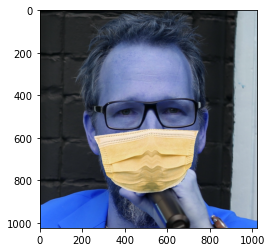

In [3]:
plt.imshow(img)

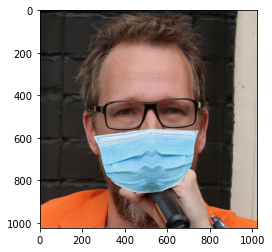

In [4]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [5]:
img.shape

(1024, 1024, 3)

In [6]:
base_dir = 'dataset\\'
classes = ['with_mask', 'without_mask']

masked_dir = os.path.join('./dataset/with_mask')
without_masked_dir = os.path.join('./dataset/without_mask')

In [7]:
masked_names = os.listdir(masked_dir)
print(masked_names[:10])

without_masked_names = os.listdir(without_masked_dir)
print(without_masked_names[:10])

['00000_Mask.jpg', '00001_Mask.jpg', '00002_Mask.jpg', '00003_Mask.jpg', '00004_Mask.jpg', '00005_Mask.jpg', '00006_Mask.jpg', '00007_Mask.jpg', '00008_Mask.jpg', '00009_Mask.jpg']
['00000.png', '00001.png', '00002.png', '00003.png', '00004.png', '00005.png', '00006.png', '00007.png', '00008.png', '00009.png']


In [8]:
# base_dir = 'dataset\\'

# classes = ['with_mask', 'without_mask']
# i=1
# for clas in classes:
#     img_path = os.path.join(base_dir, clas)
#     plt.subplot(1,5,i)
#     print('{} images in {} class'.format(len(os.listdir(img_path)), clas))
#     imgs =  os.listdir(img_path)
    
#     for image in imgs[:5]:
#         #plt.subplot(1,5,1)
#         img = cv.imread(os.path.join(img_path, image))
#         plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
#         plt.show()
#     i=i+1
      

In [8]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

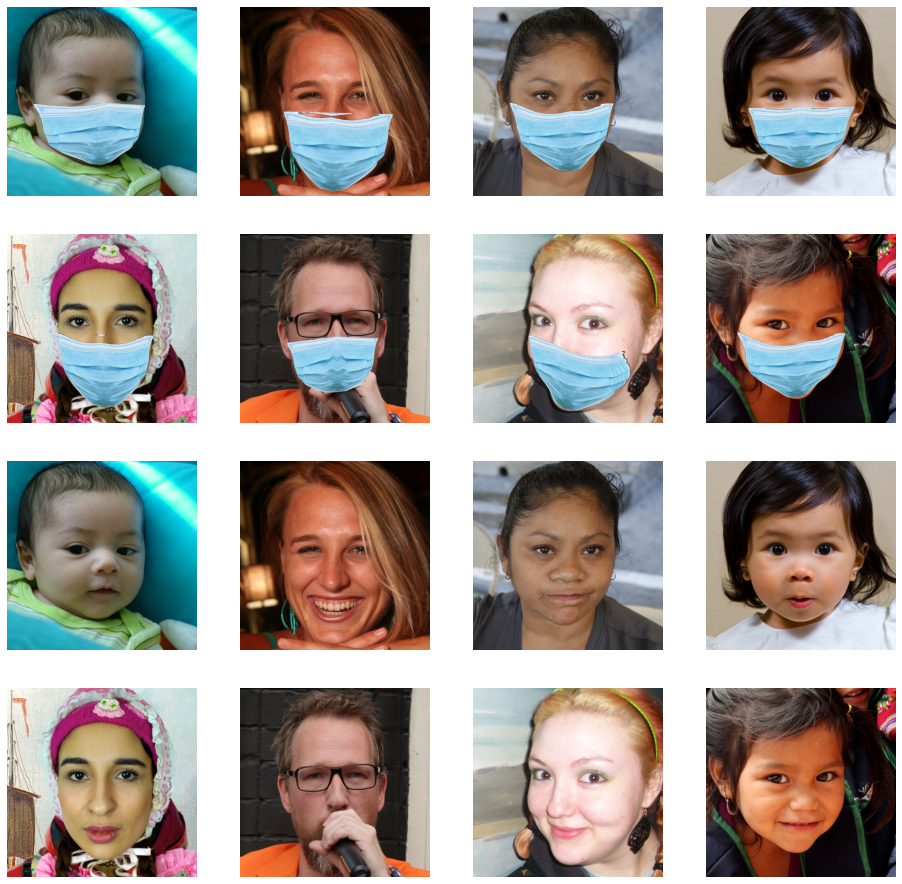

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_masked_pix = [os.path.join(masked_dir, fname) 
                for fname in masked_names[pic_index-8:pic_index]]
next_without_masked_pix = [os.path.join(without_masked_dir, fname) 
                for fname in without_masked_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_masked_pix+next_without_masked_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [10]:
# def resize_images(clas, img_size=224):
    
#     path = os.path.join(base_dir, clas)
    
#     for img in os.listdir(path):
#         image_array = cv.imread(os.path.join(path, img))
    
#         new_size_img = cv.resize(image_array, (img_size, img_size))
#         plt.imshow(cv.cvtColor(new_size_img, cv.COLOR_BGR2RGB))
#         plt.show()
#         break

In [11]:
# resize_images('With_mask')
# resize_images('Without_mask')

In [12]:
for cl in classes:
    img_path = os.path.join(base_dir, cl)
    print('{} images in {} class'.format(len(os.listdir(img_path)), cl))
    images = glob.glob(img_path + '/*.jpg')+glob.glob(img_path + '/*.png')
    train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]
    for t in train:
        if not os.path.exists(os.path.join(base_dir, 'train', cl)):
            os.makedirs(os.path.join(base_dir, 'train', cl))
        shutil.move(t, os.path.join(base_dir, 'train', cl))

    for v in val:
        if not os.path.exists(os.path.join(base_dir, 'val', cl)):
            os.makedirs(os.path.join(base_dir, 'val', cl))
        shutil.move(v, os.path.join(base_dir, 'val', cl))

950 images in with_mask class
1000 images in without_mask class


In [13]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [14]:
batch_size = 32
IMAGE_RES = 150
image_gen_train = ImageDataGenerator(rescale=1./255)

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                               shuffle=True,
                                               target_size=(IMAGE_RES, IMAGE_RES),
                                               directory=train_dir,
                                                     class_mode='binary')
image_gen_val = ImageDataGenerator(rescale=1./255.)
val_data_gen = image_gen_val.flow_from_directory(directory=val_dir,
                                               target_size=(IMAGE_RES,IMAGE_RES),
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 1560 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


In [114]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow_hub as hub

In [115]:
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, 
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))
feature_extractor.trainable = False
model = tf.keras.Sequential([feature_extractor,
                            tf.keras.layers.Dense(1,activation='sigmoid')])

In [116]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_6 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [117]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy')>0.9995):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model_stop_training = True

In [118]:
callback = myCallback()

In [119]:
model.compile(
  optimizer=RMSprop(learning_rate=0.0001), 
  loss='binary_crossentropy',
  metrics=['accuracy'])

history = model.fit(train_data_gen,
                    validation_data=val_data_gen,
                    epochs=6,
                   verbose=2, callbacks=callback)

Epoch 1/6
49/49 - 75s - loss: 0.6284 - accuracy: 0.7038 - val_loss: 0.3185 - val_accuracy: 0.8897 - 75s/epoch - 2s/step
Epoch 2/6
49/49 - 68s - loss: 0.2092 - accuracy: 0.9423 - val_loss: 0.1379 - val_accuracy: 0.9641 - 68s/epoch - 1s/step
Epoch 3/6
49/49 - 67s - loss: 0.0960 - accuracy: 0.9814 - val_loss: 0.0795 - val_accuracy: 0.9795 - 67s/epoch - 1s/step
Epoch 4/6
49/49 - 65s - loss: 0.0556 - accuracy: 0.9910 - val_loss: 0.0565 - val_accuracy: 0.9846 - 65s/epoch - 1s/step
Epoch 5/6
49/49 - 67s - loss: 0.0380 - accuracy: 0.9942 - val_loss: 0.0446 - val_accuracy: 0.9897 - 67s/epoch - 1s/step
Epoch 6/6
49/49 - 67s - loss: 0.0285 - accuracy: 0.9936 - val_loss: 0.0396 - val_accuracy: 0.9897 - 67s/epoch - 1s/step


In [124]:
mymodel = model.save('model_v1.h5')

In [125]:
with open('model_v1.h5', 'rb') as f_in:
    with gzip.open('model_v1.h5.gz', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

## Optional: Transfer learning - Create the pre-trained model

In [116]:
# if you use colab, run this code
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [109]:
# if you use jupyter notebook, run this code
# uncomment the code and run
#wget.download('https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [15]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [16]:
def create_pre_trained_model(local_weights_file):
    
    pre_trained_model = InceptionV3(input_shape=(IMAGE_RES,IMAGE_RES,3),
                                   include_top=False)
    pre_trained_model.load_weights(local_weights_file)
    for layer in pre_trained_model.layers:
        layer.trainable = False
        
    return pre_trained_model

In [17]:
pre_trained_model = create_pre_trained_model(local_weights_file)
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 7, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 7, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 7, 7, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 3, 3, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 3, 3, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 3, 3, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

In [18]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print('Total number of parameters in this model: ', total_params)
print('Total number of trainable parameters in this model: ', num_trainable_params)

Total number of parameters in this model:  21802784
Total number of trainable parameters in this model:  0


In [19]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model_stop_training = True
            

In [20]:
def output_of_last_layer(pre_trained_model):
    last_desired_layer = pre_trained_model.get_layer('mixed7')
    print('last layer output shape: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)
    return last_output

In [21]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [22]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [115]:
def create_final_model(pre_trained_model, last_output):
    x = layers.Flatten()(last_output)
    x = sparsity.prune_low_magnitude(layers.Dense(1024, activation='relu'),**pruning_params)(x)
    x = layers.Dropout(0.2)(x)
    x = sparsity.prune_low_magnitude(layers.Dense(1, activation='sigmoid'),**pruning_params)(x)
    
    model = Model(inputs=pre_trained_model.input, outputs=x)
    model.compile(optimizer=RMSprop(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [116]:
model = create_final_model(pre_trained_model, last_output)
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])
print('Total number of parameters in this model: ', total_params)
print('Total number of trainable parameters in this model: ', num_trainable_params)

Total number of parameters in this model:  86048677
Total number of trainable parameters in this model:  38537217


In [122]:
model.fit(train_data_gen,
                    validation_data=val_data_gen, epochs=2, callbacks=callbacks)

Epoch 1/2
49/49 [==============================] - 84s 2s/step - loss: 0.0213 - accuracy: 0.9859 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 2/2
49/49 [==============================] - 76s 2s/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 2.1615e-04 - val_accuracy: 1.0000


In [68]:
callback = myCallback()
history = model.fit(train_data_gen,
                    validation_data=val_data_gen,
                    epochs=2,
                   verbose=2,
                   callbacks=callbacks)

Epoch 1/2

Epoch 1: saving model to model_checkpoints
49/49 - 77s - loss: 0.0222 - accuracy: 0.9897 - val_loss: 0.0381 - val_accuracy: 0.9872 - 77s/epoch - 2s/step
Epoch 2/2

Reached 99.9% accuracy so cancelling training!

Epoch 2: saving model to model_checkpoints
49/49 - 70s - loss: 2.9379e-04 - accuracy: 1.0000 - val_loss: 2.4872e-04 - val_accuracy: 1.0000 - 70s/epoch - 1s/step


# Save model

In [ ]:
mymodel = model.save('model_v2.h5',include_optimizer=False )

In [75]:
import gzip

In [77]:
with open('model_v2.h5', 'rb') as f_in:
    with gzip.open('model_v2.h5.gz', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Check the model for predictions

In [128]:
model = tf.keras.models.load_model('model_v1.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [129]:
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [93]:
import ipywidgets as widgets
from IPython.display import display
from tensorflow.keras.utils import load_img, img_to_array
import io
import PIL.Image as Image

uploader = widgets.FileUpload(accept='*.jpg',
                             multiple=True)

display(uploader)


FileUpload(value={}, accept='*.jpg', description='Upload', multiple=True)

face.jpg


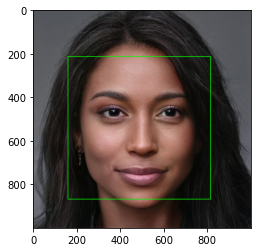

1/1 [==============================] - 0s 84ms/step
[[0.74061346]]
No mask
____________________________________________________________
Face-Masks.jpg


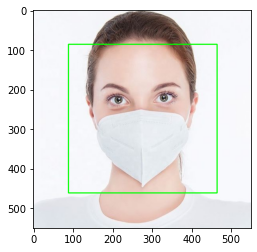

1/1 [==============================] - 0s 87ms/step
[[0.00053428]]
Masked
____________________________________________________________
masked3.jpg
No face detected
No face detected
No face detected
No face detected


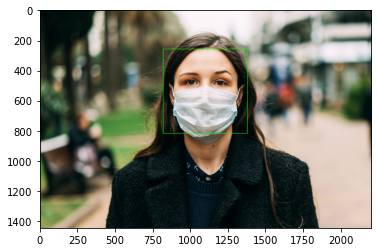

1/1 [==============================] - 0s 99ms/step
[[0.12193709]]
Masked
____________________________________________________________
no_mask1.jpg


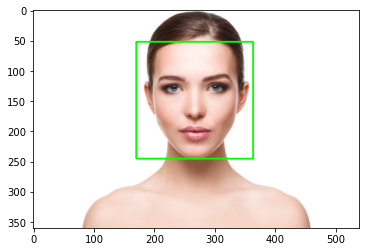

1/1 [==============================] - 0s 105ms/step
[[0.9437595]]
No mask
____________________________________________________________


In [131]:
for fn in list(uploader.value.values()):
    fn = fn['metadata']['name']
    print(fn)
    frame = cv.imread(fn)
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    #print(faces)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        #cv.rectangle(frame, (x,y),(x+w,y+h), (0,255,0), 2)
        #print(x,y,w,h)
        next_faces = face_cascade.detectMultiScale(roi_gray, 1.1, 4)
        if len(next_faces) == 0:
            print('No face detected')
        else:
            for ex,ey,ew,eh in next_faces:
                cv.rectangle(frame, (x,y),(x+w,y+h), (0,255,0), 2)
                #print(x,y,w,h)
                roi_face = roi_color[ey:ey+eh, ex:ex+ew]
              
    plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
    plt.show()
    roi_face = cv.resize(roi_face, (150,150))
    image = np.expand_dims(roi_face, axis=0)
    image = image/255.0
    prediction = model.predict(image)
    print(prediction)
    if prediction<0.5:
        print('Masked')
    else:
        print('No mask')
    print('_'*60)

# Real time  face mask  detection

In [1]:
font_scale = 1.5
font= cv.FONT_HERSHEY_PLAIN
rectangle_bgr = (255,255,255)
img=np.zeros((500,500))
text= 'some text'
(text_width, text_height) = cv.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]
text_offset_x=10
text_offset_y=img.shape[0]-25
box_cords = ((text_offset_x, text_offset_y), (text_offset_x+text_width+2, text_offset_y-text_height-2))
cv.rectangle(img, box_cords[0], box_cords[1], rectangle_bgr, cv.FILLED)
cv.putText(img, text, (text_offset_x, text_offset_y), font, fontScale=font_scale, color=(0,0,0), thickness=1)

cap = cv.VideoCapture(0)
if not cap.isOpened():
    cap = cv.VideoCapture(1)
if not cap.isOpened():
     raise IOError('Cannot open the camera')
        
while True:
    ret, frame = cap.read()
    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = frame[y:y+h,x:x+w]
        cv.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), 2)
        next_faces = face_cascade.detectMultiScale(roi_gray)
        if len(next_faces)==0:
            print('No face detected')
        else:
            for ex,ey,ew,eh in next_faces:
                face_roi = roi_color[ey:ey+eh,ex:ex+ew]
    print(roi_color.shape)
    
    roi_face = cv.resize(face_roi, (150,150))
    image = np.expand_dims(roi_face, axis=0)
    image = image/255.0
    prediction = model.predict(image)
    
    if prediction<0.5:
        status = 'Masked: '+str(int(100-prediction*100))+'%'
        cv.rectangle(frame, (x,y), (x+w,y+h), (0,255,0))
        cv.rectangle(frame, (x,y+h), (x+150,y+h+30), (0,255,0), thickness=-1)
        cv.putText(frame, status, (x+8, y+h+20), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255),1)
    else:
        status = 'No Mask: '+str(int(prediction*100))+'%'
        cv.rectangle(frame, (x,y), (x+w,y+h), (0,0,255))
        cv.rectangle(frame, (x,y+h), (x+150,y+h+30), (0,0,255), thickness=-1)
        cv.putText(frame, status, (x+8, y+h+20), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255),1)
    
    cv.imshow('Face Mask Detection', frame)
    
    if cv.waitKey(2) & 0xFF == ord('q'):
        break
    
    
cap.release()
cv.destroyAllWindows()

# Deploy Machine Learning to the Web with Deepnote and Anvil

In [119]:
import anvil